In [46]:
import torch
import torchvision
import random
from PIL import Image
from torch import nn
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import os
from pathlib import Path
import shutil
from torchvision import datasets
from torch.utils.data import DataLoader
import ssl
import torcheval
from torcheval.metrics import BinaryAccuracy
from tqdm.auto import tqdm


In [47]:
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device=torch.device('mps')


In [48]:
data_path = Path("/Users/sahilpambhar/Downloads/archive")
ai_dir = data_path / "AiArtData" / "AiArtData"
real_dir = data_path / "RealArt" / "RealArt"

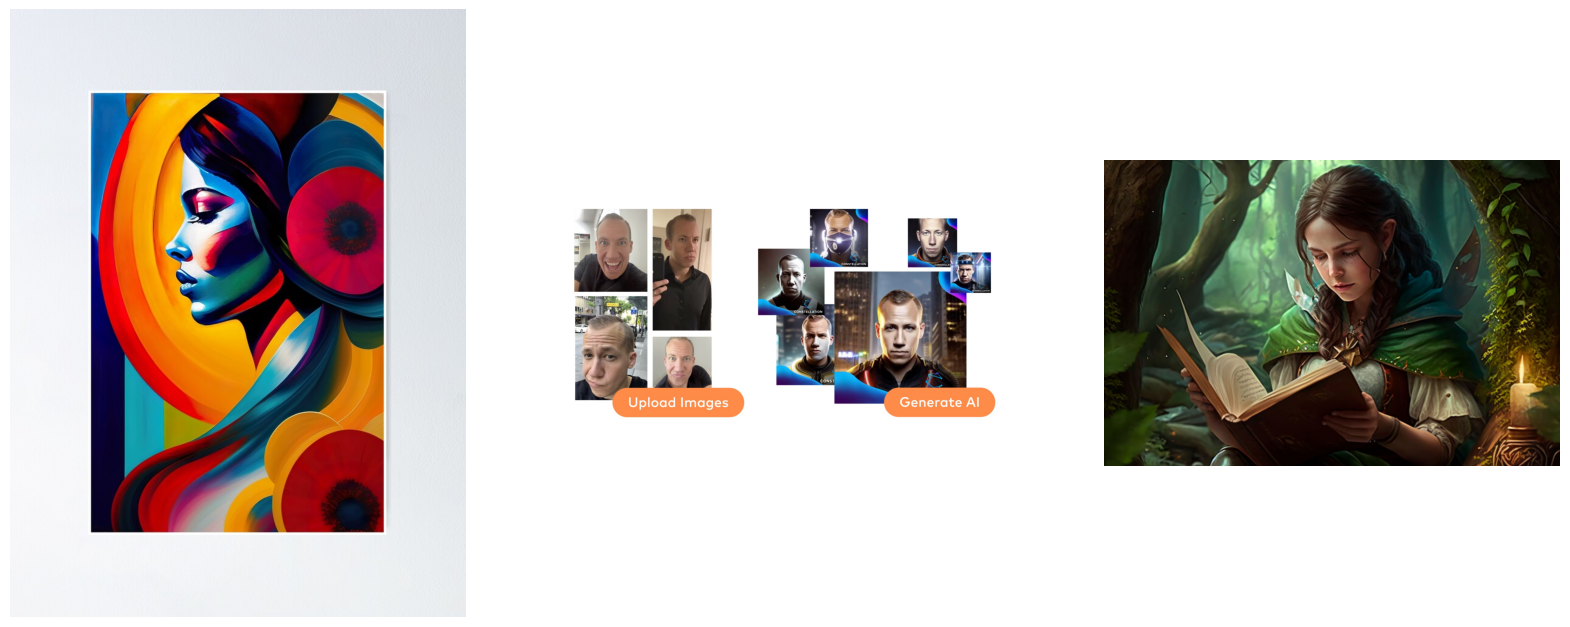

In [49]:
ai_image_path_list = list(Path(ai_dir).glob("*.jpg"))
random_ai_image = random.sample(ai_image_path_list, k=3)
plt.figure(figsize=(20, 15))

i = 1
for image_path in random_ai_image:
    plt.subplot(1, 3, i)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis(False)
    i += 1

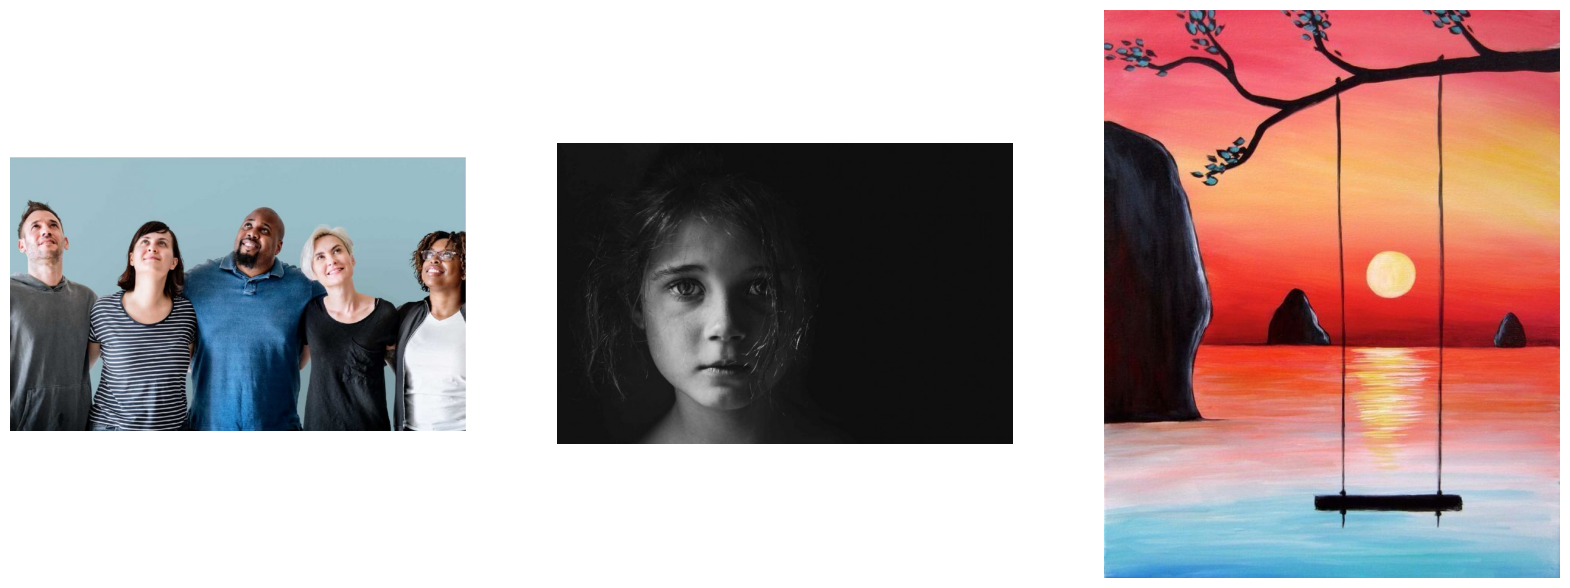

In [5]:
real_image_path_list = list(Path(real_dir).glob("*.jpg"))
random_real_image = random.sample(real_image_path_list, k=3)
plt.figure(figsize=(20, 15))

i = 1
for image_path in random_real_image:
    plt.subplot(1, 3, i)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis(False)
    i += 1

In [6]:
new_data_path = Path("kaggle/working/data")
new_data_path.mkdir(parents=True, exist_ok=True)

train_path = new_data_path / "train"
test_path = new_data_path / "test"

os.mkdir(train_path)
os.mkdir(test_path)

train_ai_split = int(len(ai_image_path_list) * 0.8)
train_real_split = int(len(real_image_path_list) * 0.8)

train_ai_img = random.sample(ai_image_path_list, k=train_ai_split)
train_real_img = random.sample(real_image_path_list, k=train_real_split)

test_ai_img = []
test_real_img = []

for ai_img in ai_image_path_list:
    if ai_img not in train_ai_img:
        test_ai_img.append(ai_img)
    
for real_img in real_image_path_list:
    if real_img not in train_real_img:
        test_real_img.append(real_img)
print(f"ai_image_path_list: {len(ai_image_path_list)}")
print(f"real_image_path_list: {len(real_image_path_list)}")
print(f"train_ai_img: {len(train_ai_img)}")
print(f"train_real_img: {len(train_real_img)}")
print(f"test_ai_img: {len(test_ai_img)}")
print(f"test_real_img: {len(test_real_img)}")

ai_image_path_list: 385
real_image_path_list: 378
train_ai_img: 308
train_real_img: 302
test_ai_img: 77
test_real_img: 76


In [50]:
train_ai_path = train_path / "AiArt"
train_real_path = train_path / "RealArt"
test_ai_path = test_path / "AiArt"
test_real_path = test_path / "RealArt"

os.mkdir(train_ai_path)
os.mkdir(train_real_path)
os.mkdir(test_ai_path)
os.mkdir(test_real_path)

FileExistsError: [Errno 17] File exists: 'kaggle/working/data/train/AiArt'

In [51]:
for img in train_ai_img:
    shutil.copy(img, train_ai_path)
for img in train_real_img:
    shutil.copy(img, train_real_path)
for img in test_ai_img:
    shutil.copy(img, test_ai_path)
for img in test_real_img:
    shutil.copy(img, test_real_path)

In [52]:
weights = torchvision.models.ResNet152_Weights.DEFAULT
weights

ResNet152_Weights.IMAGENET1K_V2

In [53]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [54]:
train_data = datasets.ImageFolder(root=train_path,
                                 transform=auto_transforms)
test_data = datasets.ImageFolder(root=test_path,
                                transform=auto_transforms)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 610
    Root location: kaggle/working/data/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 153
    Root location: kaggle/working/data/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [55]:
class_names = train_data.classes
class_names

['AiArt', 'RealArt']

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-0.9192, -0.9192, -0.8164,  ..., -0.5938, -0.5424, -0.6794],
         [-1.0733, -1.0219, -0.9705,  ..., -0.4226, -0.4739, -0.6281],
         [-1.0390, -1.0390, -0.9020,  ..., -0.6623, -0.6623, -0.6965],
         ...,
         [-0.9192, -1.1760, -1.1418,  ..., -0.6281, -0.6965, -0.8335],
         [-1.0733, -0.9534, -1.1075,  ..., -0.3883, -0.3541, -0.4226],
         [-1.1589, -0.7308, -0.9534,  ..., -0.1657, -0.1828, -0.2684]],

        [[-1.2129, -1.1779, -1.1078,  ..., -0.7052, -0.6527, -0.7752],
         [-1.3529, -1.2829, -1.3004,  ..., -0.5476, -0.6001, -0.7577],
         [-1.3004, -1.3179, -1.2479,  ..., -0.8102, -0.8277, -0.8452],
         ...,
         [-1.0903, -1.3354, -1.3704,  ..., -1.0553, -1.0903, -1.2129],
         [-1.2654, -1.1253, -1.3354,  ..., -0.8627, -0.8627, -0.9153],
         [-1.3179, -0.9153, -1.1779,  ..., -0.6527, -0.7402, -0.8102]],

        [[-1.3513, -1.2990, -1.2119,  ..., -0.6193, -0.5844, -0.6890],
         [-1.3861, -1.3164, -1.

In [70]:
# ssl._create_default_https_context = ssl._create_unverified_context
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
num_workers = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=32,
                             num_workers=4,
                             shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=num_workers,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x33a7c5910>,
 <torch.utils.data.dataloader.DataLoader at 0x33a76b090>)

In [73]:
print(type("mps"))

<class 'str'>


In [71]:
# model = torchvision.models.resnet152(weights="IMAGENET1K_V2").to(device)
model = torchvision.models.resnet152(weights="IMAGENET1K_V2").to(device).

In [59]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [60]:
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = False

In [61]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [62]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [63]:
model.fc = nn.Sequential(
nn.Dropout(p=0.5),   
nn.Linear(in_features=2048, out_features=1024, bias=True),
nn.Dropout(p=0.5),
nn.Linear(in_features=1024, out_features=1, bias=True),
)

In [64]:
model.fc

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1, bias=True)
)

In [65]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [66]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    metric = BinaryAccuracy(threshold=0.5)
    metric.update(y_pred, y_true)
    return metric.compute().item()

In [68]:
accuracy_fn(torch.tensor([0, 0, 0, 1]), torch.Tensor([0.2, 0.9, 0.9, 0.9]))

0.5

In [69]:

img, label = next(iter(train_dataloader))
print(len(img))
pred = model(img.to("mps"))

print(pred.squeeze())
print(torch.sigmoid(pred.squeeze()))
pred.squeeze().shape, label.shape
# print("Input type:", img.dtype)
# print("Weight type:", next(model.parameters()).dtype)


32


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [35]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X).squeeze()
        
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy_fn(y_true=y, y_pred=torch.sigmoid(y_pred))
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_pred_logits = model(X).squeeze()
            
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()
            
            test_acc += accuracy_fn(y_true=y, y_pred=torch.sigmoid(test_pred_logits))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [36]:
def train(model: torch.nn.Module,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         accuracy_fn,
         epochs: int = 5):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          accuracy_fn=accuracy_fn)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [38]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()

results = train(model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               epochs=10)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(results)

In [ ]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# from timeit import default_timer as timer

# start_time = timer()

# results_20_epochs = train(model=model,
#                loss_fn=loss_fn,
#                optimizer=optimizer,
#                accuracy_fn=accuracy_fn,
#                train_dataloader=train_dataloader,
#                test_dataloader=test_dataloader,
#                epochs=20)

# end_time = timer()

# print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


In [ ]:
# plot_loss_curves(results_20_epochs)

In [ ]:
MODEL_PATH = Path("kaggle/working/model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet152_ai_vs_real_img_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(),
          f=MODEL_SAVE_PATH)

In [ ]:
# import torchvision
# import torch
# from pathlib import Path
# import matplotlib as plt
# model = torchvision.models.resnet152(weights="IMAGENET1K_V2")
# model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
# model.load_state_dict(torch.load(f="/kaggle/input/resnet152_ai_vs_real_img_model/pytorch/model/1/resnet152_ai_vs_real_img_model.pth", map_location=torch.device("cpu")))
# device = "cpu"
# model = model.to(device)


In [ ]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        label,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device,
                       ):
    
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    model.to(device)

    model.eval()
    with torch.inference_mode():
      
      transformed_image = image_transform(img).unsqueeze(dim=0)

      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.sigmoid(target_image_pred).squeeze()
    target_image_pred_label = torch.round(target_image_pred_probs).int()


    plt.figure()
    plt.imshow(img)
    if class_names[target_image_pred_label] == label:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs:.3f} | Label: {label}", c="g")
    else:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs:.3f} | Label: {label}", c="r")
    plt.axis(False);

In [ ]:
import random
num_images_to_plot = 5
test_real_list = list(Path(test_path).glob("RealArt/*.jpg")) 
test_real_sample = random.sample(population=test_real_list, 
                                       k=num_images_to_plot) 
test_ai_list = list(Path(test_path).glob("AiArt/*.jpg")) 
test_ai_sample = random.sample(population=test_ai_list, 
                                       k=num_images_to_plot) 


for image_path in test_real_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224),
                       label="RealArt")
for image_path in test_ai_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224),
                       label="AiArt")

In [ ]:
test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn)
print(f"Accuracy of model on test data: {test_acc * 100 :.3f}%")